In [1]:
import pandas as pd
import numpy as np

df_40 = pd.read_csv("Data/all_opinions_1940.csv")
df_40['date_filed'] = df_40['date_filed'].apply(pd.to_datetime, errors='coerce')
df_40['author_lastname'] = df_40.author_name.apply(lambda x: x.split(" ")[-1]) #get last name of each justice
df_40['author_lastname'] = np.where((df_40['author_lastname'] == 'Roberts') & (df_40['year_filed']<2005), 'Roberts, O.', df_40['author_lastname'])
df_40 = df_40[df_40['per_curiam']==False] # per curiam opinions are opinions the court deemed to be so straightforward there is no named author
df_40 = df_40.drop(columns=['Unnamed: 0','federal_cite_one','absolute_url','cluster','per_curiam'])

print(df_40.shape)
print(df_40.dtypes)
df_40.head(3)

(14924, 11)
author_name                        object
category                           object
case_name                          object
date_filed                 datetime64[ns]
year_filed                          int64
scdb_id                            object
scdb_decision_direction           float64
scdb_votes_majority               float64
scdb_votes_minority               float64
text                               object
author_lastname                    object
dtype: object


,author_name,category,case_name,date_filed,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,author_lastname
0,Justice Roberts,majority,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,Roberts
1,Justice Thomas,concurring,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...,Thomas
2,Justice Breyer,dissenting,McCutcheon v. Federal Election Comm'n,2014-04-02,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U...",Breyer


In [2]:
from datetime import datetime
df_justice = pd.read_csv("./Data/JusticeData.csv")
df_justice = df_justice.drop(columns=['StateApptFrom'])
df_justice['JusticeLastName'] = df_justice.Name.apply(lambda x: x.split(",")[0]) #get last name of each justice
df_justice[['DateServiceTerminated','JudicialOathTaken']] = df_justice[['DateServiceTerminated','JudicialOathTaken']].apply(pd.to_datetime, errors='coerce')
df_justice['JusticeLastName'] = np.where((df_justice['JusticeLastName'] == 'Roberts') & (df_justice['DateServiceTerminated']<datetime.strptime('January 1, 2005', '%B %d, %Y')), 'Roberts, O.', df_justice['JusticeLastName'])
df_justice = df_justice[(df_justice['DateServiceTerminated'] >= datetime.strptime('January 1, 1940', '%B %d, %Y')) | (df_justice['DateServiceTerminated'].isna()==True)]
df_justice = df_justice.drop_duplicates(subset='Name', keep='first')
df_justice.fillna({'ChiefJustice': 0}, inplace=True)

print(df_justice.shape)
print(df_justice.dtypes)

(44, 6)
ChiefJustice                    float64
Name                             object
AppointedByPresident             object
JudicialOathTaken        datetime64[ns]
DateServiceTerminated    datetime64[ns]
JusticeLastName                  object
dtype: object


In [3]:
df_presidents = pd.read_csv("./Data/PresidentialParty.csv",usecols=['PRESIDENT','POLITICAL PARTY'])
print(df_presidents.shape)
print(df_presidents.dtypes)

df_presidents['LastName'] = df_presidents['PRESIDENT'].apply(lambda x: x.split(" ")[-1]) #get last name of each pres
df_presidents.loc[41, 'LastName'] = 'Bush, G. W.' #deal with weird cases of same last name 
df_presidents.loc[39, 'LastName'] = 'Bush, G. H. W.' 
df_presidents.loc[34, 'LastName'] = 'Johnson, L.'
df_presidents.loc[30, 'LastName'] = 'Roosevelt, F.'
df_presidents.loc[24, 'LastName'] = 'Roosevelt, T.'
df_presidents.loc[8, 'LastName'] = 'Harrison, W. H.'  
df_presidents.loc[5, 'LastName'] = 'Adams, J. Q.'
df_presidents.loc[1, 'LastName'] = 'Adams, J.'  

(45, 2)
PRESIDENT          object
POLITICAL PARTY    object
dtype: object


In [4]:
df_justice.AppointedByPresident = df_justice.AppointedByPresident.astype(str)
df_presidents.LastName = df_presidents.LastName.astype(str)
df_justice = df_justice.merge(df_presidents, left_on='AppointedByPresident', right_on='LastName', how='left').drop(columns=['PRESIDENT','LastName'])
df_40 = df_40.merge(df_justice, left_on='author_lastname', right_on='JusticeLastName', how="left").drop(columns=['author_lastname','JusticeLastName','Name'])

In [5]:
df_40[df_40['POLITICAL PARTY'].isna() == True] #Let's drop these
df_40 = df_40.dropna(subset = 'POLITICAL PARTY')

In [6]:
#Text field is the opinion
#important: Authorname, case_name, category, date_filed,

In [7]:
# df_40 = df_40[df_40['author_name'] != 'Justice Or']
# df_40 = df_40[df_40['author_name'] != 'Justice And']
# df_40 = df_40[df_40['author_name'] != 'Justice O2122']

## Transforming Data

We are going to create lists of the authors of every case and their political affiliation. 

In [8]:
authors = df_40['author_name']
category = df_40['category']
case_name = df_40['case_name']
year = df_40['year_filed']
political_aff = df_40['POLITICAL PARTY']
case_txt = df_40['text']
case_id = df_40['scdb_id']

* We are going to create a list of lists that have the words of the cases

In [9]:
import re

stop_words = ['..','__','___','___','_','-','--','there','.',';',':','the','to','in','rt','of','a', 'for','and','is','on','amp','you','i','at','will','our','we','be','with','that','it','this','are','https','s','have','by','from','has','all','as','not','was','out','t','your','my','who','her','me','he','about','so','make','just''2','w','she','they','us','his','if','up','again','an','what','one','no','here','but','can','last','than','were','do','would','been','am','http','had','when','made','them','or','there','another','isil','aumf','youre']
w_txt = [sentence.lower().split() for sentence in case_txt] #CHANGE AT THE END!!!

words_txt = [[word for word in k if word not in stop_words 
            and re.match('[a-zA-Z]+$', word)] for k in w_txt]

* Let's see the frequency of the words

In [10]:
words = [word for sentence in words_txt for word in sentence]

from collections import Counter

freq = Counter(words)
f = sorted([(freq[k],k) for k in freq], reverse = True)

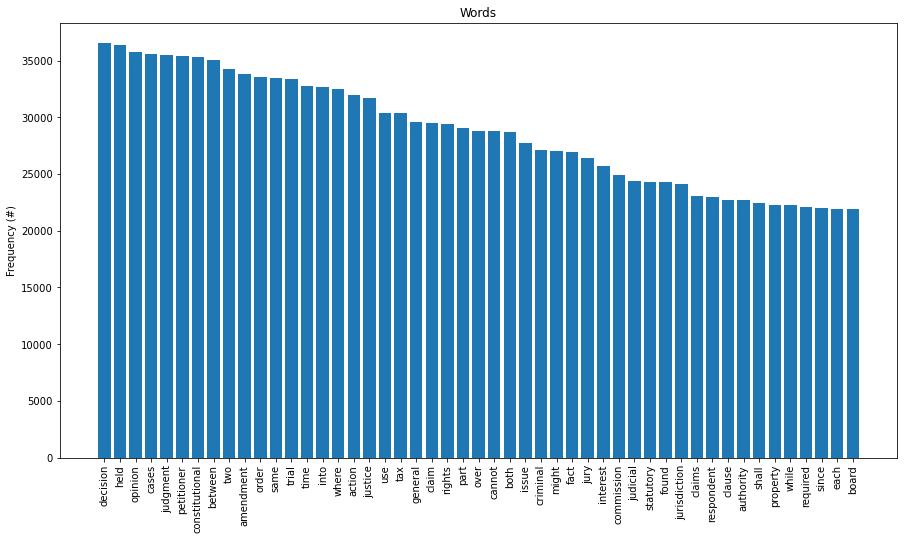

In [13]:
import matplotlib.pyplot as plt

fr = f[51:100]
w_w = [k for v,k in fr]
f_w = [v for v,k in fr]
plt.figure(figsize=(15, 8))
plt.bar(w_w,f_w)
plt.ylabel("Frequency (#)")
plt.title("Words")
plt.xticks(rotation=90)
plt.show()

* Let's differentiate between Republicans and Democrats

In [14]:
df_R_40 = df_40[df_40['POLITICAL PARTY'] == 'Republican']
df_D_40 = df_40[df_40['POLITICAL PARTY'] == 'Democratic']

In [15]:
l = range(len(political_aff))

## DEMOCRATS
w_txt = [sentence.lower().split() for sentence in df_D_40['text']]
words_txt_D = [[word for word in k if word not in stop_words 
            and re.match('[a-zA-Z]+$', word)] for k in w_txt]
words_D = [word for sentence in words_txt_D for word in sentence]
freq_D = Counter(words_D)
f_D = sorted([(freq_D[k],k) for k in freq_D], reverse = True)
w_w_D = [k for v,k in f_D]
f_w_D = [v for v,k in f_D]

## REPUBLICANS
w_txt = [sentence.lower().split() for sentence in df_R_40['text']]
words_txt_R = [[word for word in k if word not in stop_words 
            and re.match('[a-zA-Z]+$', word)] for k in w_txt]

words_R = [word for sentence in words_txt_R for word in sentence]
freq_R = Counter(words_R)
f_R = sorted([(freq_R[k],k) for k in freq_R], reverse = True)
w_w_R = [k for v,k in f_R]
f_w_R = [v for v,k in f_R]

* Frequency of words for each Democratic and Republican party

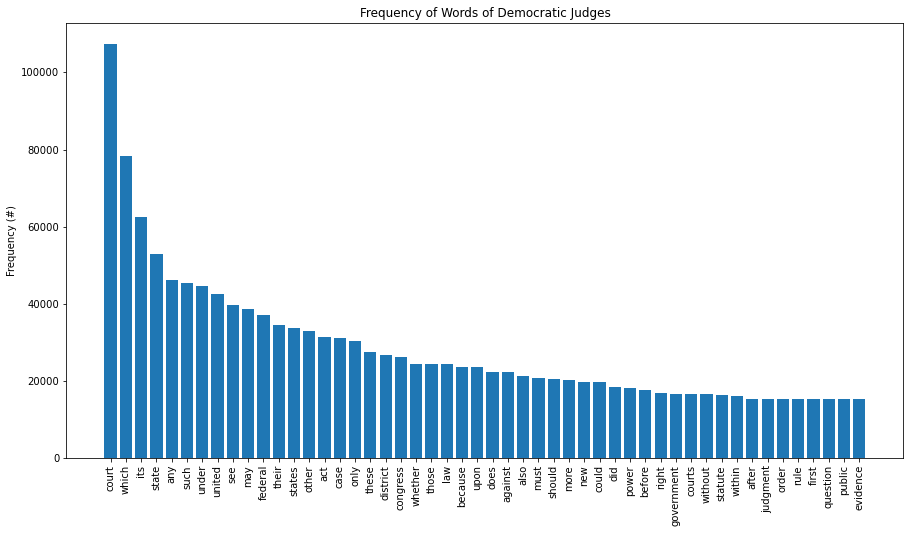

In [16]:
plt.figure(figsize=(15, 8))
plt.bar(w_w_D[:50],f_w_D[:50])
plt.title("Frequency of Words of Democratic Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

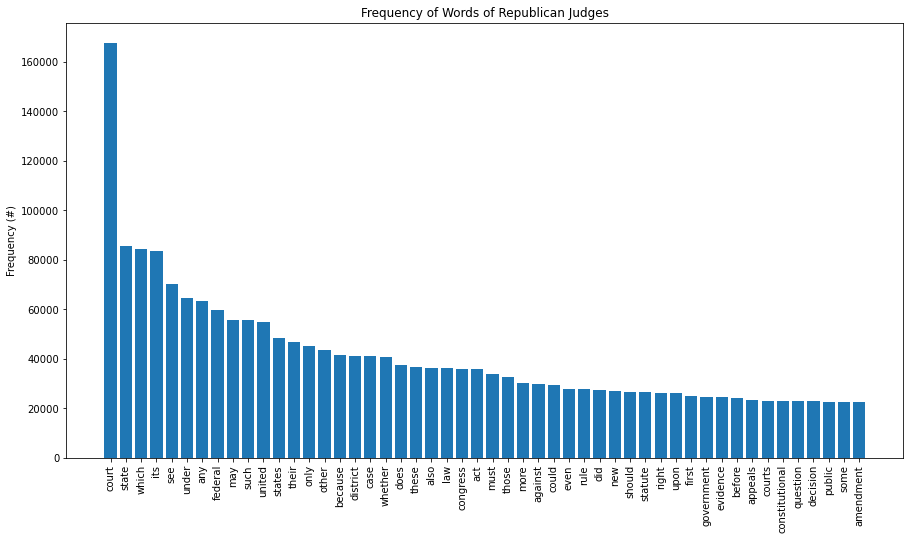

In [17]:
plt.figure(figsize=(15, 8))
plt.bar(w_w_R[:50],f_w_R[:50])
plt.title("Frequency of Words of Republican Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

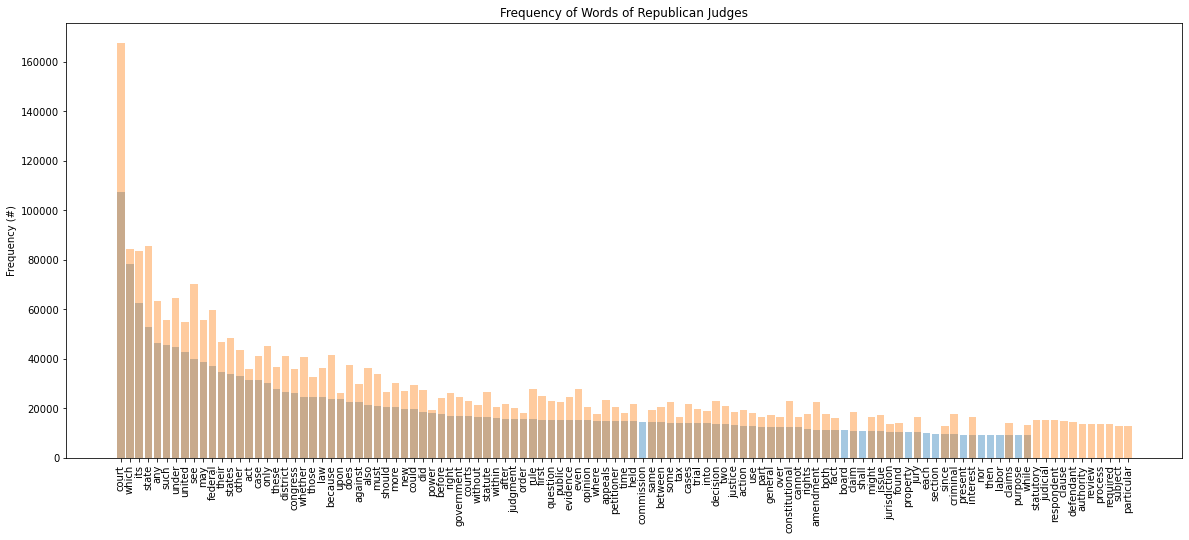

In [18]:
plt.figure(figsize=(20, 8))
plt.bar(w_w_D[:100],f_w_D[:100], alpha=0.4)
plt.bar(w_w_R[:100],f_w_R[:100], alpha=0.4)
plt.title("Frequency of Words of Republican Judges")
plt.ylabel("Frequency (#)")
plt.xticks(rotation=90)
plt.show()

## PMI

In [ ]:
import math

only_words_txt = [list(set(only_words)) for only_words in words_txt] #unique words per sentence

words_one_per_sentence = [word for sentence in only_words_txt for word in sentence]
count_words = Counter(words_one_per_sentence)
total_words = len(words_one_per_sentence)

no_sentences = len(only_words_txt)

count_words = Counter(words_one_per_sentence)

count_democratic_words = Counter()
count_Republican_words = Counter()

#Probability word and Democratic
for s in range(len(only_words_txt)):
    if political_aff[s] == 'Democratic':
        for word in only_words_txt[s]:
            count_democratic_words[word] += 1
    if political_aff[s] == 'Republican':
        for word in only_words_txt[s]:
            count_Republican_words[word] += 1

prob_words = {word : (count_words[word]/no_sentences) for word in count_words}
            
prob_democratic_words = {word : (count_democratic_words[word]/no_sentences) for word in count_democratic_words}
prob_Republican_words = {word : (count_Republican_words[word]/no_sentences) for word in count_Republican_words}

prob_democratic_sentences = sum([1 for i in political_aff if i == 'Democratic'])/no_sentences
prob_republican_sentences = sum([1 for i in political_aff if i == 'Republican'])/no_sentences



In [ ]:
#PMI for every word and Democrats
PMI_Words_and_Democrats = sorted([(math.log(prob_democratic_words[word]/(prob_words[word]*prob_democratic_sentences)), word) 
                                  for word in prob_words 
                                  if word in prob_democratic_words and count_democratic_words[word] > 10], reverse = True)

#PMI for every word and Republicans
PMI_Words_and_Republicans = sorted([(math.log(prob_Republican_words[word]/(prob_words[word]*prob_republican_sentences)), word) 
                                    for word in prob_words 
                                    if word in prob_Republican_words and count_Republican_words[word] > 10], reverse = True)


print("\nWords with largest PMI's for Democrats:")
for i in range(50):
    print(str(i+1) + '.', PMI_Words_and_Democrats[i][1] + ':', PMI_Words_and_Democrats[i][0])
    
print("\nWords with largest PMI's for Republicans:")
for i in range(50):
    print(str(i+1) + '.', PMI_Words_and_Republicans[i][1] + ':', PMI_Words_and_Republicans[i][0])

Latent Dirichlet Allocation

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=5, suppress=True)

len (df_40)

14915

In [34]:
vocab_size = 1000
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
df_R_40 = df_R_40[df_R_40['category'] == 'majority']
df_D_40 = df_D_40[df_D_40['category'] == 'majority']

tf_vectorizer = CountVectorizer(max_df = 0.5, #discuss max_df, min_df 
                                min_df = 1,
                                stop_words ='english',
                                max_features = vocab_size)

tf_R = tf_vectorizer.fit_transform(df_R_40["text"]) #read text column only for republicans
tf_D = tf_vectorizer.fit_transform(df_D_40["text"]) #read text column only for democrats


We now fit an LDA model to the data

In [35]:
num_topics = 10 #discuss num_topics- how to pick this number 

from sklearn.decomposition import LatentDirichletAllocation
lda_R = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_D = LatentDirichletAllocation(n_components=num_topics, random_state=0)

lda_R.fit(tf_R)
lda_D.fit(tf_D)

LatentDirichletAllocation(random_state=0)

In [36]:
topic_word_distributions_R = np.array([row / row.sum() for row in lda_R.components_])
topic_word_distributions_D = np.array([row / row.sum() for row in lda_D.components_])

In [37]:
num_top_words = 10 #double check 

def print_top_words(topic_word_distributions, num_top_words, vectorizer):
    vocab = vectorizer.get_feature_names()
    num_topics = len(topic_word_distributions)
    print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
    print()

    for topic_idx in range(num_topics):
        print('[Topic ', topic_idx, ']', sep='')
        sort_indices = np.argsort(-topic_word_distributions[topic_idx])
        for rank in range(num_top_words):
            word_idx = sort_indices[rank]
            print(vocab[word_idx], ':',
                  topic_word_distributions[topic_idx, word_idx])
        print()

print_top_words(topic_word_distributions_R, num_top_words, tf_vectorizer)

print_top_words(topic_word_distributions_D, num_top_words, tf_vectorizer)

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
jury : 0.02598837526844848
defendant : 0.01823759196657591
criminal : 0.015844149151482603
counsel : 0.014458048074213465
judge : 0.013963818350720913
respondent : 0.010817038031253709
conviction : 0.009083234685458692
sentence : 0.008516998378685426
testimony : 0.008405500474724655
habeas : 0.007921934797195709

[Topic 1]
tax : 0.05406993570900286
property : 0.03227442710951239
income : 0.02032089661364178
bank : 0.013361062590274218
business : 0.013193255339794534
value : 0.01292888757023756
taxes : 0.012174577583356487
corporation : 0.011641164266609697
bankruptcy : 0.01087885852561788
paid : 0.009759768287099421

[Topic 2]
commission : 0.04577976694399703
commerce : 0.020101745690199145
interstate : 0.016964199803843692
price : 0.013652259715059628
patent : 0.0119694998404141
market : 0.010982051720659684
rate : 0.010162133275226205
gas : 0.009968911758737974
rates : 0.009662136120661685
se

C:\Users\ktnha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
#pip install https://github.com/sulunemre/word_cloud/releases/download/2/wordcloud-0.post1+gd8241b5-cp39-cp39-win_amd64.whl

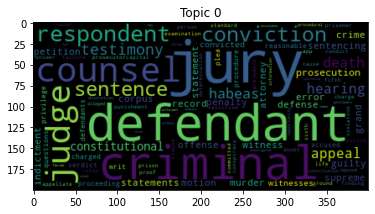

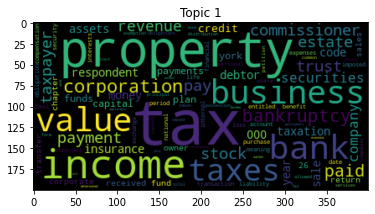

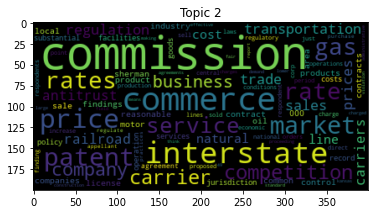

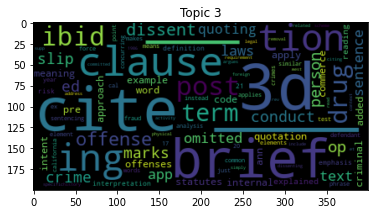

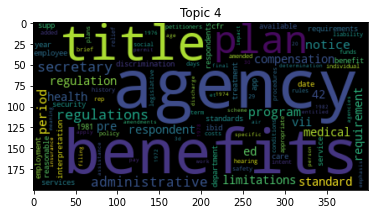

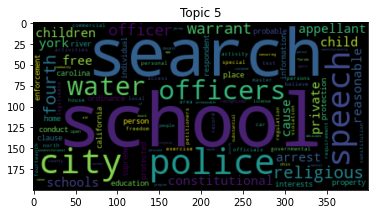

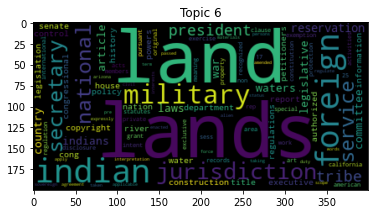

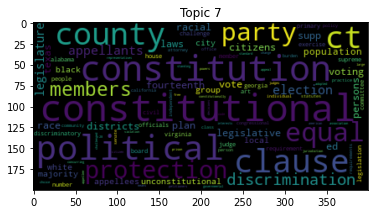

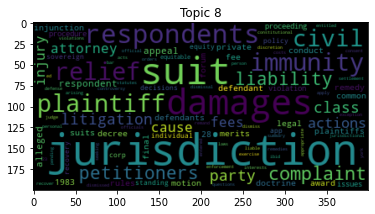

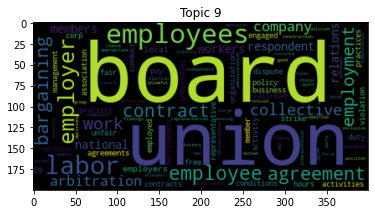

In [39]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tf_vectorizer.get_feature_names()
num_topics = len(topic_word_distributions_R)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions_R[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

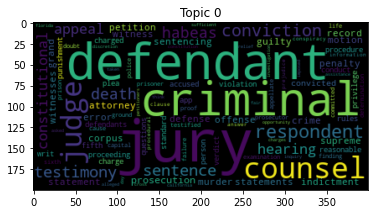

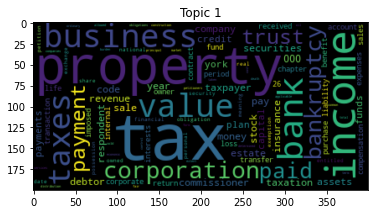

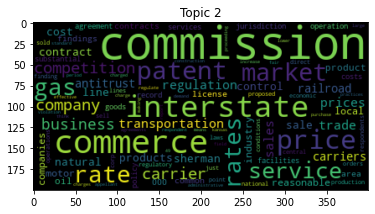

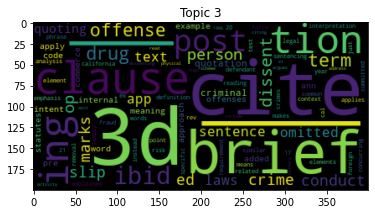

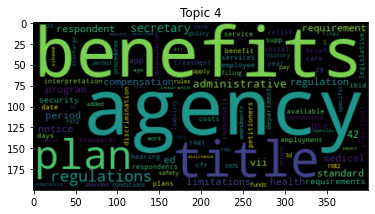

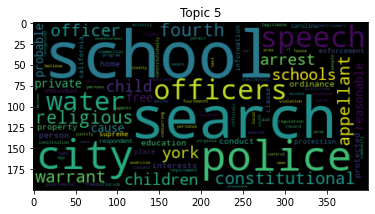

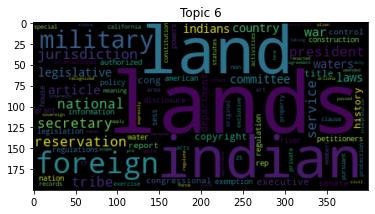

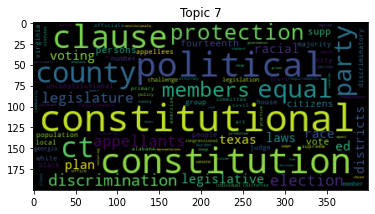

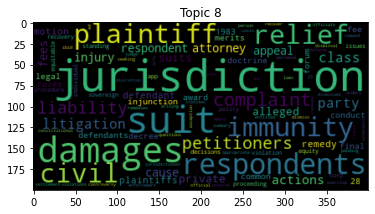

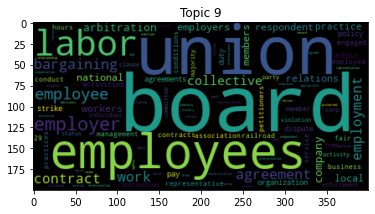

In [40]:
from wordcloud import WordCloud

num_max_word_cloud_words = 100

vocab = tf_vectorizer.get_feature_names()
num_topics = len(topic_word_distributions_R)

for topic_idx in range(num_topics):
    wc = WordCloud(max_words=num_max_word_cloud_words)
    wc.generate_from_frequencies(dict(zip(vocab, topic_word_distributions_D[topic_idx])))
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Topic %d' % topic_idx)

#### Topic 9 - employer and labour
#### Topic 5 - school board, education
#### Topic 7 - Gerrymandering?
#### Topic 0 - death penalty?

In [41]:
tf = tf_vectorizer.fit_transform(df_40["text"]) #read text column only 
lda = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda.fit(tf)

doc_topic_matrix = lda.transform(tf)

lsa_300_df = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lsa_300_df.head()

,author_name,year_filed,case_name,category,0,1,2,3,4,5,6,7,8,9
0,Justice Roberts,2014,McCutcheon v. Federal Election Comm'n,majority,0.241168,0.047250,0.010905,0.029064,0.000042,0.422564,0.000042,0.000042,0.241372,0.007550
1,Justice Thomas,2014,McCutcheon v. Federal Election Comm'n,concurring,0.500062,0.000338,0.000338,0.000338,0.000338,0.179375,0.000338,0.000338,0.318197,0.000338
2,Justice Breyer,2014,McCutcheon v. Federal Election Comm'n,dissenting,0.343650,0.050345,0.000052,0.063394,0.000052,0.349489,0.000052,0.000052,0.192863,0.000052
3,Justice Kagan,2014,Kaley v. United States,majority,0.291114,0.085595,0.000060,0.007939,0.167652,0.000060,0.000060,0.447400,0.000060,0.000060
4,Justice Roberts,2014,Kaley v. United States,dissenting,0.189359,0.100565,0.000075,0.005427,0.248294,0.000075,0.000075,0.453673,0.000075,0.002381


In [42]:
lda_df = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lda_by_year = lda_df[['year_filed'] + list(range(num_topics))].groupby('year_filed').agg('mean')
lda_by_year.head()

,0,1,2,3,4,5,6,7,8,9
year_filed,,,,,,,,,,
1940,0.013403,0.336020,0.046996,0.025304,0.136760,0.077228,0.168236,0.041559,0.045904,0.108589
1941,0.010289,0.318903,0.056463,0.031714,0.130044,0.085961,0.168419,0.064551,0.049374,0.084282
1942,0.033540,0.248588,0.043871,0.028746,0.111999,0.079899,0.208714,0.087180,0.048247,0.109217
1943,0.019199,0.234043,0.076562,0.038696,0.108313,0.077034,0.186602,0.105672,0.052113,0.101765
1944,0.021003,0.227114,0.049055,0.032149,0.109039,0.093539,0.220625,0.077490,0.040548,0.129439


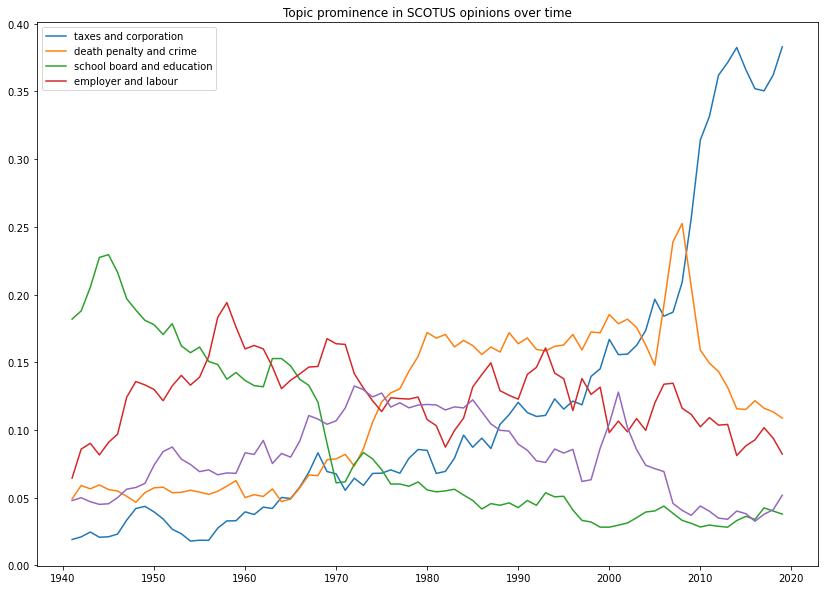

In [43]:
x = lda_by_year.index[1:-1]
plt.figure(figsize=(14,10))

for feature in [1,3,7,8,9]:
    y_vals = list(lda_by_year[feature-1])
    y = [(y_vals[j] + y_vals[j-1] + y_vals[j+1])/3 for j in range(1, len(y_vals)-1)] # rolling mean for smoothing
    plt.plot(x,y)
plt.legend(labels=[
    'taxes and corporation',
    'death penalty and crime',
    'school board and education',
    'employer and labour'
])  
plt.title("Topic prominence in SCOTUS opinions over time")
plt.show()

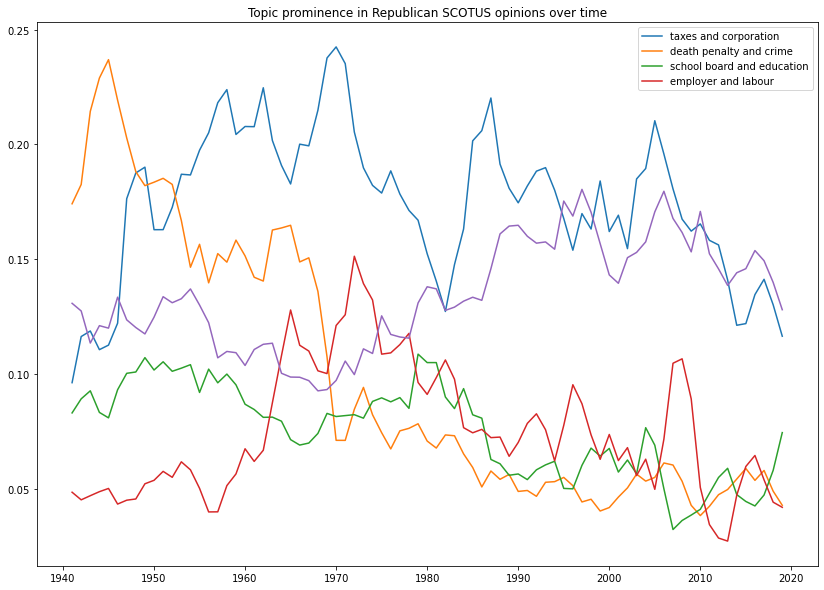

In [44]:
doc_topic_matrix = lda_R.transform(tf_R)

lda_R_df = pd.concat(
    [
        df_R_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lda_by_year = lda_R_df[['year_filed'] + list(range(num_topics))].groupby('year_filed').agg('mean')
lda_by_year.head()

x = lda_by_year.index[1:-1]
plt.figure(figsize=(14,10))

for feature in [1,3,7,8,9]:
    y_vals = list(lda_by_year[feature-1])
    y = [(y_vals[j] + y_vals[j-1] + y_vals[j+1])/3 for j in range(1, len(y_vals)-1)] # rolling mean for smoothing
    plt.plot(x,y)
plt.legend(labels=[
    'taxes and corporation',
    'death penalty and crime',
    'school board and education',
    'employer and labour'
])  
plt.title("Topic prominence in Republican SCOTUS opinions over time")
plt.show()

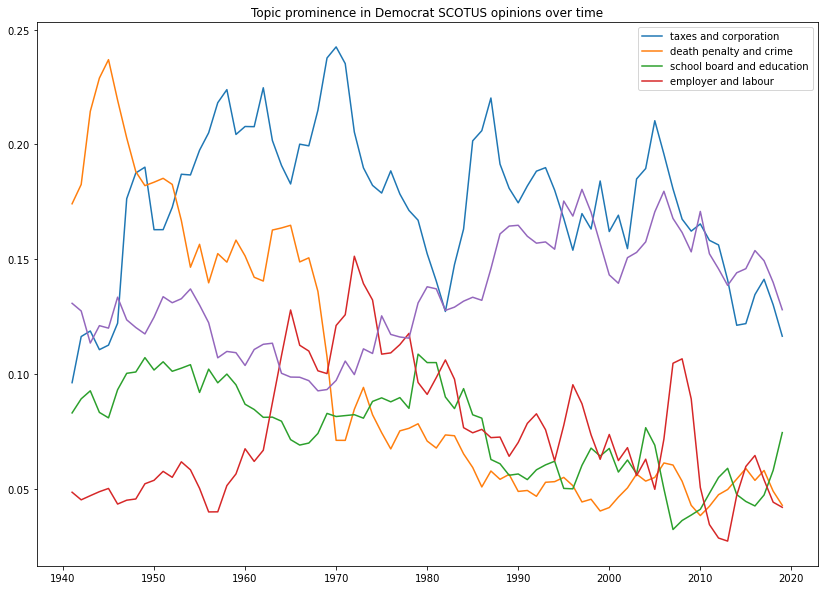

In [45]:
doc_topic_matrix = lda_D.transform(tf_D)

lda_D_df = pd.concat(
    [
        df_D_40[['author_name','year_filed','case_name', 'category']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lda_by_year = lda_D_df[['year_filed'] + list(range(num_topics))].groupby('year_filed').agg('mean')
lda_by_year.head()

x = lda_by_year.index[1:-1]
plt.figure(figsize=(14,10))

for feature in [1,3,7,8,9]:
    y_vals = list(lda_by_year[feature-1])
    y = [(y_vals[j] + y_vals[j-1] + y_vals[j+1])/3 for j in range(1, len(y_vals)-1)] # rolling mean for smoothing
    plt.plot(x,y)
plt.legend(labels=[
    'taxes and corporation',
    'death penalty and crime',
    'school board and education',
    'employer and labour'
])  
plt.title("Topic prominence in Democrat SCOTUS opinions over time")
plt.show()

In [46]:
import seaborn as sns
temporal_sequence = df_40.groupby('author_name').agg('mean').year_filed.sort_values().index
corr_df = lsa_300_df.drop('category', axis=1).groupby('author_name').agg('mean').T.corr()
typicality = corr_df.sum(axis=1)

mask = np.zeros_like(corr_df, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
sns.set(style="white")

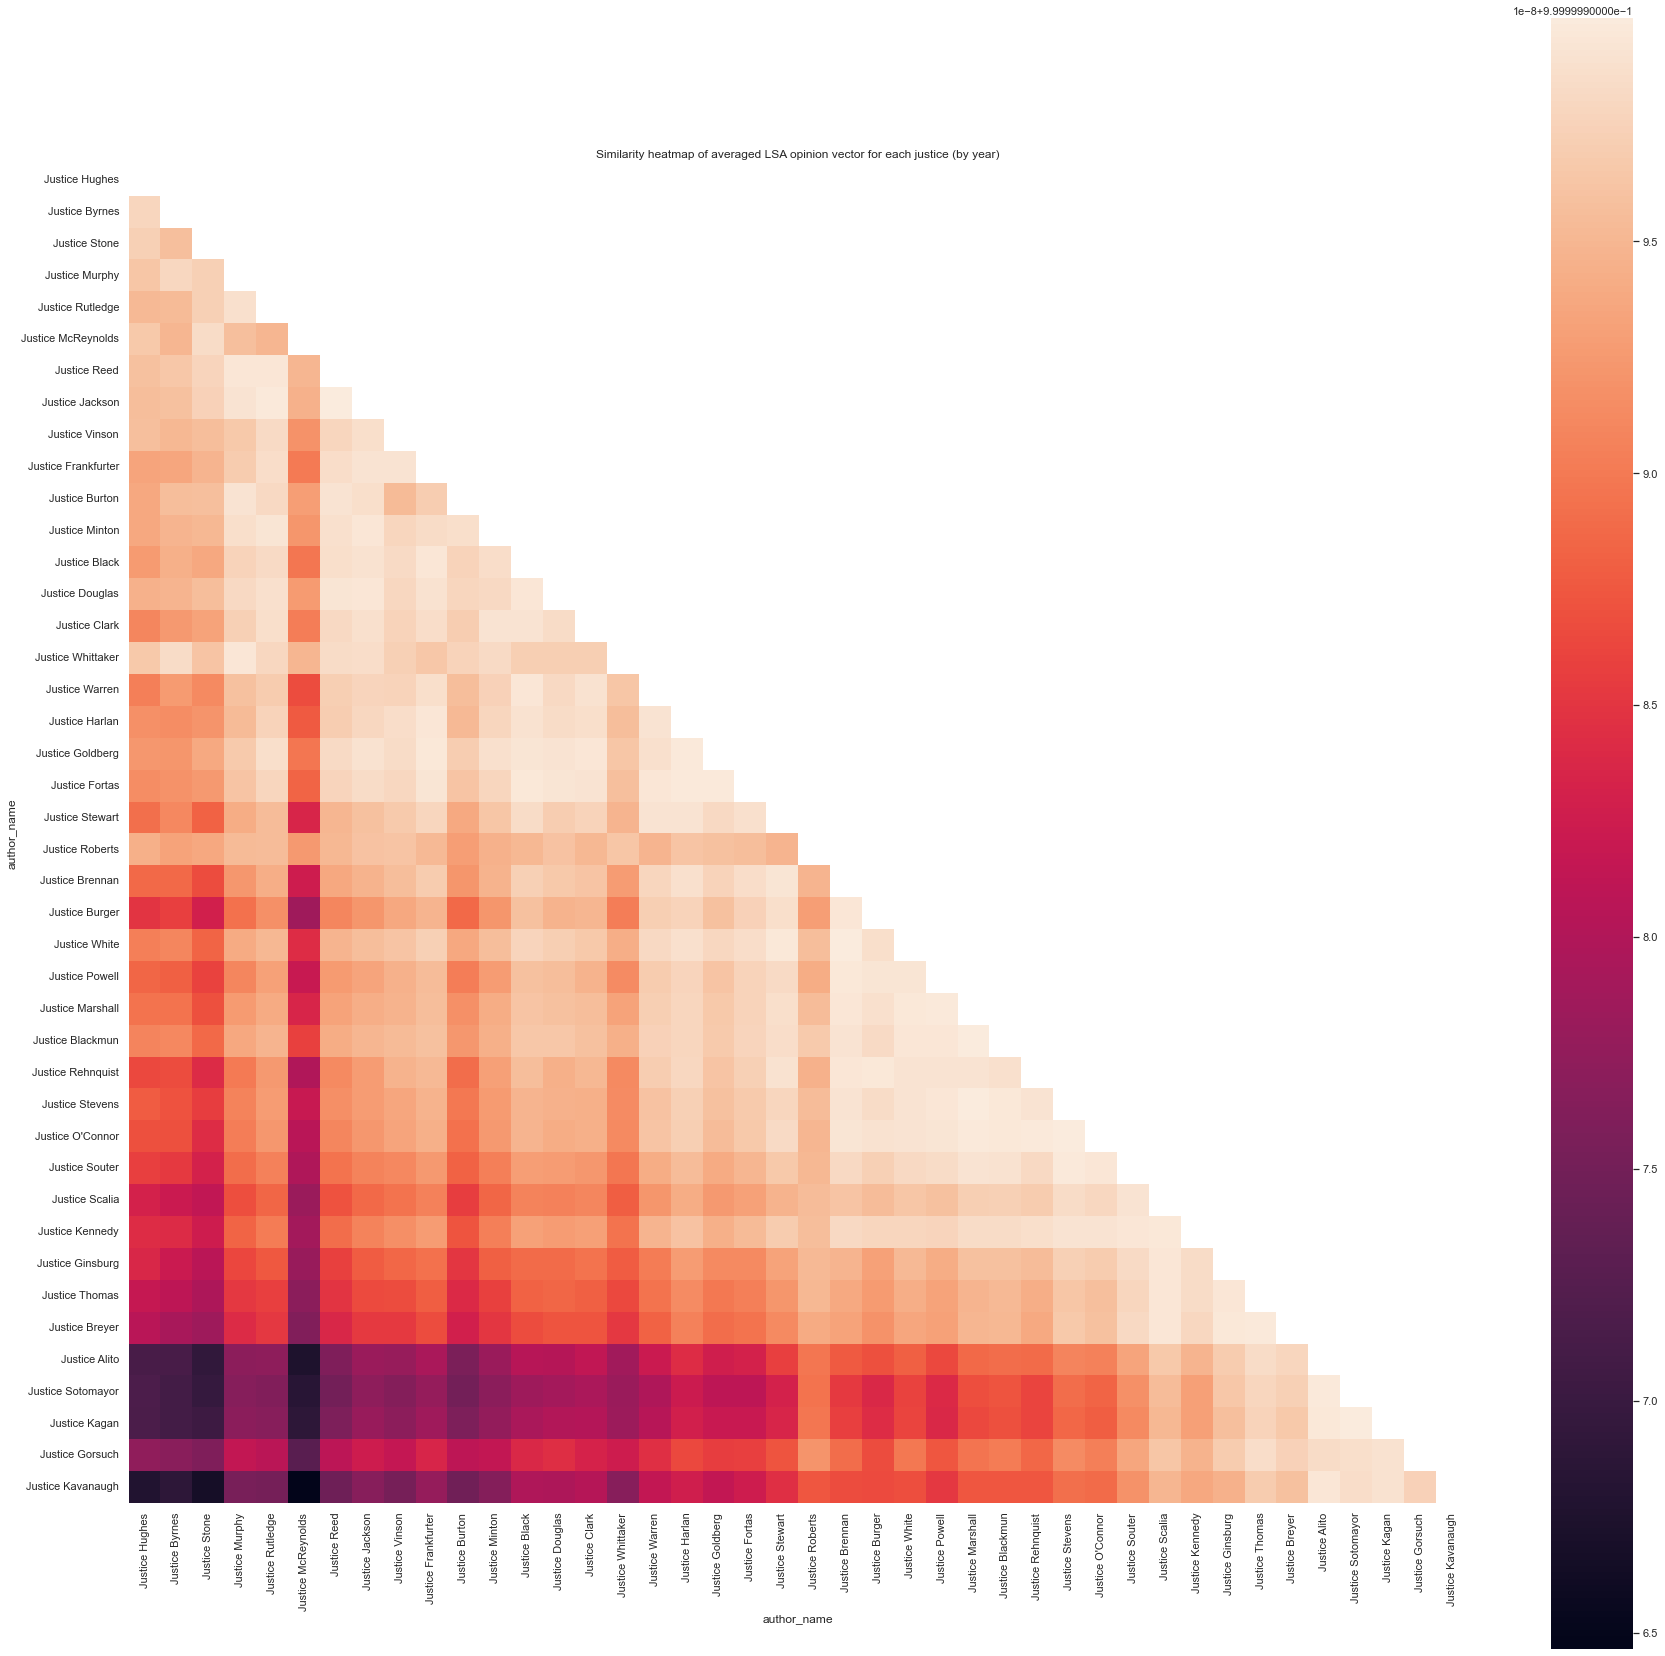

In [47]:
plt.figure(figsize=(30,30))
sns.heatmap(
    lsa_300_df.drop('category', axis=1).groupby('author_name').agg('mean').T.corr().loc[
        temporal_sequence, temporal_sequence
    ],
    square=True,
    mask=mask
)
plt.title("Similarity heatmap of averaged LSA opinion vector for each justice (by year)")
plt.show()

In [48]:
lsa_300_df2 = pd.concat(
    [
        df_40[['author_name','year_filed','case_name', 'category', 'POLITICAL PARTY']].reset_index(drop=True), 
        pd.DataFrame(doc_topic_matrix)
    ],
    axis=1)

lsa_300_df2.head()

,author_name,year_filed,case_name,category,POLITICAL PARTY,0,1,2,3,4,5,6,7,8,9
0,Justice Roberts,2014,McCutcheon v. Federal Election Comm'n,majority,Republican,0.000046,0.038074,0.000046,0.253678,0.056778,0.000046,0.032588,0.608700,0.000046,0.010000
1,Justice Thomas,2014,McCutcheon v. Federal Election Comm'n,concurring,Republican,0.634924,0.083448,0.000068,0.172448,0.000068,0.099029,0.000068,0.000068,0.009811,0.000068
2,Justice Breyer,2014,McCutcheon v. Federal Election Comm'n,dissenting,Democratic,0.000326,0.964121,0.026279,0.000326,0.000326,0.007319,0.000326,0.000326,0.000326,0.000326
3,Justice Kagan,2014,Kaley v. United States,majority,Democratic,0.000104,0.000104,0.221225,0.192159,0.000104,0.369729,0.000104,0.185107,0.031260,0.000104
4,Justice Roberts,2014,Kaley v. United States,dissenting,Republican,0.000108,0.000108,0.000108,0.000108,0.069931,0.000108,0.000108,0.000108,0.139568,0.789747


In [49]:
lda_by_pp = lsa_300_df2[['POLITICAL PARTY'] + list(range(num_topics))].groupby('POLITICAL PARTY').agg('mean')
lda_by_pp.head()

,0,1,2,3,4,5,6,7,8,9
POLITICAL PARTY,,,,,,,,,,
Democratic,0.174750,0.107291,0.114208,0.060317,0.093781,0.096302,0.074780,0.073178,0.127725,0.077669
Republican,0.169027,0.113186,0.097794,0.057928,0.099809,0.092929,0.080615,0.078112,0.134777,0.075823


In [ ]:
import numpy as np
df_40['Republican'] = np.where()